# But actually, we want to analyze repos 

In [63]:
import re
import matplotlib.pyplot as pyplot
import matplotlib
import time
from datetime import datetime
from multiprocessing import Pool
import multiprocessing
import functools

In [290]:
%load_ext autoreload
from repoLibrarian import *
%aimport repoLibrarian
%aimport repoAnalysis
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
setReposFolder('/mnt/brick/crm20/repos/')

'/mnt/brick/crm20/repos/'

In [65]:
setReposFolder('./repos/')

'./repos/'

In [5]:
getReposFolder()

'./repos/'

In [7]:
from os import listdir


def simpleRunMetric(metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    repos = list(map(lambda repo: (repo.split('/', 1)[0], repo.split('/', 1)[1]), knownRepos()))

    start = time.time()
    with Pool(int(multiprocessing.cpu_count())) as pool:
        allMetrics = pool.map(functools.partial(timedMetricPerFileForRepo, metricFunction=metricFunction, fileCountConsumer=fileCountConsumer), repos)
    end = time.time()
    print('Total Time used: '+str(end - start))
    return allMetrics

### Running metrics

In [23]:
allMetrics = simpleRunMetric(locmOf)

Time used for ('bptlab', 'fcm2cpn.git'): 0.32309722900390625
Time used for ('bptlab', 'correlation-analysis.git'): 6.87972354888916
Time used for ('bptlab', 'scylla.git'): 44.216235399246216
Time used for ('json-iterator', 'java.git'): 48.26174259185791
Time used for ('bptlab', 'cepta.git'): 61.69267416000366
Time used for ('bptlab', 'Unicorn.git'): 69.90817427635193
Time used for ('alibaba', 'arthas.git'): 191.63405680656433
Total Time used: 194.1722662448883


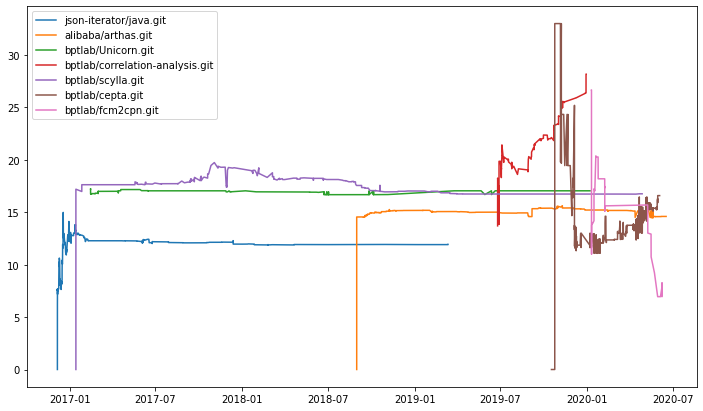

In [16]:
pyplot.figure(figsize=(12, 7))
for (timestamps, metrics) in allMetrics:
    dates = matplotlib.dates.epoch2num(timestamps)
    pyplot.plot_date(dates, metrics, '-')

pyplot.legend(list(knownRepos()))

Time used for ('bptlab', 'fcm2cpn.git'): 0.2428593635559082
Time used for ('bptlab', 'correlation-analysis.git'): 5.369837522506714
Time used for ('bptlab', 'scylla.git'): 23.692981958389282
Time used for ('json-iterator', 'java.git'): 25.463353395462036
Time used for ('bptlab', 'cepta.git'): 50.5887086391449
Time used for ('bptlab', 'Unicorn.git'): 52.17696785926819
Total Time used: 52.98057174682617


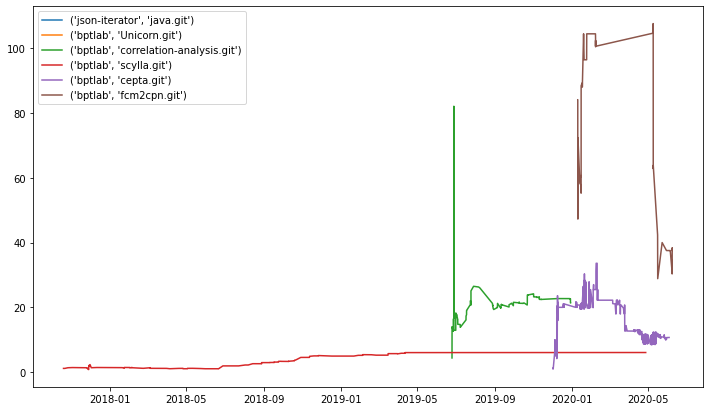

In [38]:
simpleRunMetric(lambdaDensity)

Time used for ('Elena-Zhao', 'Guimi.git'): 0.1284182071685791
Time used for ('Elena-Zhao', 'Mini-Chatter.git'): 0.10931038856506348
Time used for ('pleonex', 'ChatRMI.git'): 0.1066889762878418
Time used for ('craigslist206', 'huffman.git'): 0.16383004188537598
Time used for ('Elena-Zhao', 'Weibao.git'): 0.24792146682739258
Time used for ('pleonex', 'CocoKiller.git'): 0.2406604290008545
Time used for ('miken22', '304-Project.git'): 0.24741840362548828
Time used for ('bptlab', 'fcm2cpn.git'): 0.2866392135620117
Time used for ('pleonex', 'NiKate-Origins.git'): 0.39778637886047363
Time used for ('JTReed', 'Porygon.git'): 0.21101975440979004
Failed to analyze ('braliar', 'jabref.git'): Reference at 'refs/heads/master' does not exist
Time used for ('tyler124', 'Monitordroid.git'): 0.23861050605773926
Time used for ('GourdErwa', 'jasper_sample.git'): 0.2540762424468994
Time used for ('JTReed', 'Porygon2.git'): 0.4825553894042969
Time used for ('shengnwen', 'WeiBaoSSE.git'): 0.5534257888793945

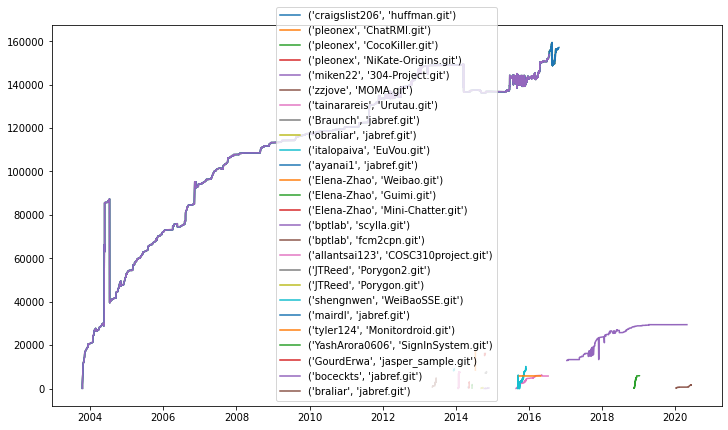

In [62]:
simpleRunMetric(loc, identity)

In [63]:
print(hasRepo('braliar','jabref'))
repo = getRepo('boceckts', 'jabref')
commit = next(repo.iter_commits())
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        print(obj.name)
        content = obj.data_stream.read().decode("CP437")
        metric = loc(content)

True
MacAdapter.java
BibDatabaseContext.java
Defaults.java
Globals.java
JabRefException.java
JabRefExecutorService.java
JabRefGUI.java
JabRefMain.java
MetaData.java
ArchitectureTests.java
BibDatabaseContextTest.java
BibtexTestData.java
FileBasedTestCase.java
FileBasedTestHelper.java
JabRefPreferencesTest.java
MetaDataTest.java
SearchQueryHighlightListenerTest.java
TestIconsProperties.java
AWTExceptionHandler.java
AbstractUITest.java
EntryTableTest.java
GUITest.java
UndoTest.java
Benchmarks.java
ArgumentProcessor.java
AuxCommandLine.java
JabRefCLI.java
Change.java
ChangeDisplayDialog.java
ChangeScanner.java
EntryAddChange.java
EntryChange.java
EntryDeleteChange.java
FileUpdateListener.java
FileUpdateMonitor.java
FileUpdatePanel.java
GroupChange.java
InfoPane.java
MetaDataChange.java
PreambleChange.java
StringAddChange.java
StringChange.java
StringNameChange.java
StringRemoveChange.java
AttachFileAction.java
AutoSetLinks.java
ConfirmCloseFileListEntryEditor.java
DownloadExternalFile.java

# Now bringing the user in

In [8]:
def isJavaFile(gitObject):
    return gitObject.type == 'blob' and gitObject.name.endswith('.java')

In [9]:
def isJavaRepo(repoTuple):
    try:
        (user, project) = repoTuple
        repo = getRepo(user, project)
        commit = list(repo.iter_commits())[0]
        return any(isJavaFile(obj) for obj in commit.tree.traverse())
    except Exception as e:
        print('Failed to check '+str(repoTuple)+': '+str(e))
        return False

In [10]:
# Delete all the duplicates except the newest
for (user, repo) in repoLibrarian.managedRepos():
    if repo.endswith('jabref.git') and not 'mairdl' in user:
        deleteRepo(user, repo)

In [66]:
basicJavaRepos = list(filter(isJavaRepo, repoLibrarian.managedRepos()))
for x in basicJavaRepos: print(x)

('json-iterator', 'java.git')
('alibaba', 'arthas.git')
('bptlab', 'Unicorn.git')
('bptlab', 'correlation-analysis.git')
('bptlab', 'scylla.git')
('bptlab', 'cepta.git')
('bptlab', 'fcm2cpn.git')


In [197]:
import collections

class Wrap:
    def __init__(self, data):
        self.data = data

def averageMetricPerCommitForRepo(repoTuple, metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    (user, project) = repoTuple
    repo = getRepo(user, project)
    try:
        start = time.time()
        commitToMetric = collections.OrderedDict()
        for commit in repo.iter_commits():
            fileCount = 0
            aggregatedMetric = 0
            totalLoc = 0
            for obj in commit.tree.traverse():
                if isJavaFile(obj):
                    fileCount = fileCount + 1
                    content = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                    loc = repoAnalysis.loc(content)
                    metric = metricFunction(content, loc=loc)
                    aggregatedMetric = aggregatedMetric + metric
                    totalLoc = totalLoc + loc
            consumedMetric = fileCountConsumer(aggregatedMetric, fileCount)
            parent = commit.parents[-1].hexsha if len(commit.parents) == 1 else None
            commitToMetric[commit.hexsha] = (commit.committed_date, consumedMetric, parent, totalLoc)
        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
    return Wrap(commitToMetric)

In [216]:
def deltasOf(metricPerCommit):
    deltas = collections.OrderedDict()
    for (sha, metric) in metricPerCommit.items():
        if(metric[2] != None): #There is a unique parent -> No merges or orphans(initial commit)
            parentMetric = metricPerCommit[metric[2]]
            deltas[sha] = (metric[0], (metric[1] - parentMetric[1]), metric[2])
    return deltas

In [19]:
def plotByDate(data):
    timestamps = map(lambda tuple: tuple[0], data)
    metrics = map(lambda tuple: tuple[1], data)
    dates = matplotlib.dates.epoch2num(list(timestamps))
    pyplot.plot_date(dates, list(metrics), '-')

In [20]:
def plotByLifecycle(data):
    if len(data) == 0:
        pyplot.plot([], [])
        return
    timestamps = map(lambda tuple: tuple[0], data)
    metrics = map(lambda tuple: tuple[1], data)
    maxDate = next(iter(data))[0]
    minDate = next(reversed(data))[0]
    interval = maxDate - minDate
    dates = list(map(lambda stamp : (stamp - minDate) / interval, timestamps))
    pyplot.plot(dates, list(metrics), '-')

### Testing if plot functions are sane

In [ ]:
data = averageMetricPerCommitForRepo(('bptlab', 'scylla'), repoAnalysis.locmOf).data

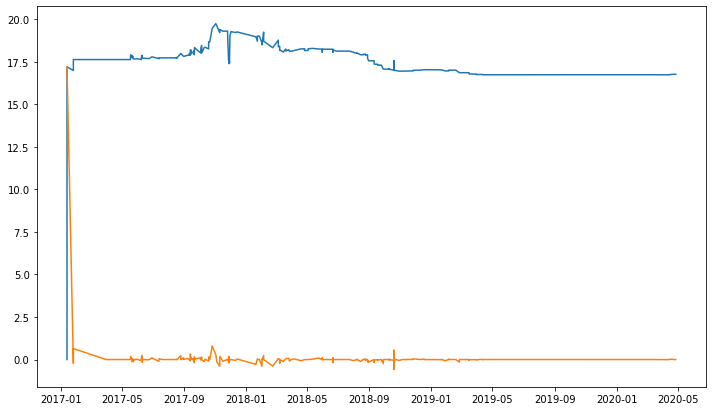

In [67]:
pyplot.figure(figsize=(12, 7))
deltas = deltasOf(data)
plotByDate(data.values())
plotByDate(deltas.values())

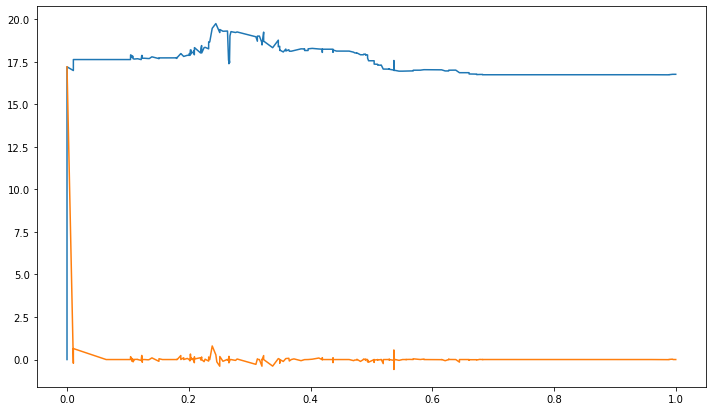

In [69]:
pyplot.figure(figsize=(12, 7))
plotByLifecycle(data)
plotByLifecycle(deltas)

### Run metrics for all repos

In [29]:
# from multiprocessing.pool import ThreadPool
# import consumers

start = time.time()
with Pool(int(multiprocessing.cpu_count()/4)) as pool:
    #allMetrics = pool.map(lambda repo: averageMetricPerCommitForRepo(repoTuple=repo, metricFunction=locmOf), basicJavaRepos)
    allMetrics = pool.map(functools.partial(averageMetricPerCommitForRepo, metricFunction=repoAnalysis.locmOf), basicJavaRepos)
allMetrics = list(map(lambda wrap: wrap.data, allMetrics))
chainMap = collections.ChainMap(*allMetrics)
end = time.time()
print('Total Time used: '+str(end - start))

Time used for ('bptlab', 'fcm2cpn.git'): 0.410602331161499
Time used for ('bptlab', 'correlation-analysis.git'): 3.3247828483581543
Time used for ('bptlab', 'scylla.git'): 27.353537559509277
Time used for ('json-iterator', 'java.git'): 29.815542936325073
Time used for ('bptlab', 'cepta.git'): 32.99368500709534
Time used for ('bptlab', 'Unicorn.git'): 38.291534662246704
Time used for ('alibaba', 'arthas.git'): 160.3558988571167
Total Time used: 161.17432641983032


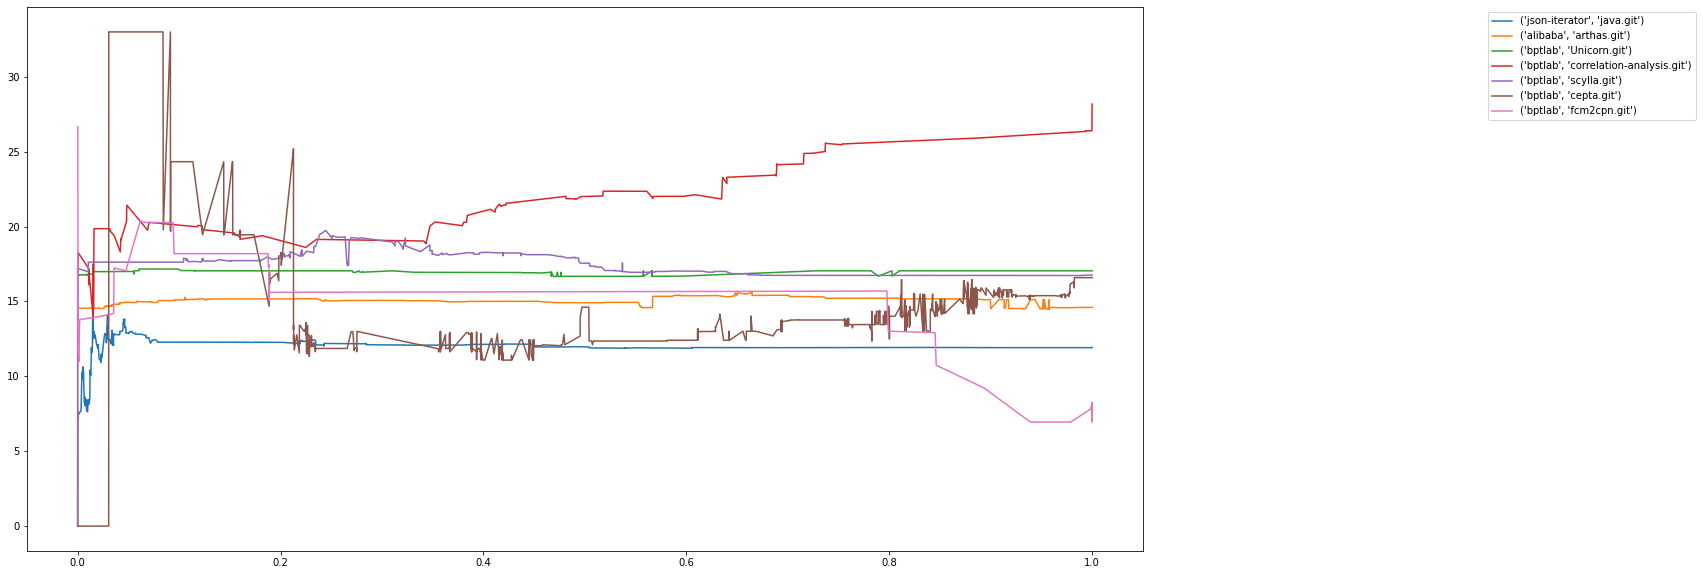

In [35]:
# reposToMetrics = dict(zip(repos, allMetrics))

pyplot.figure(figsize=(20, 10))
for data in allMetrics:
    plotByLifecycle(
        #deltasOf(
            data.values()
        #)
    )

pyplot.legend(basicJavaRepos, bbox_to_anchor=(1.5, 1.0))

In [20]:
sha = next(iter(next(iter(allMetrics))))
print(chainMap.get(sha, default=None))

(1552402499, 11.935117352548417, None)


# Starting to run suites and generate database

In [11]:
%load_ext autoreload
%aimport repoAnalysis
%aimport dbUtils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%autoreload 2
suite = repoAnalysis.metricSuite
data = repoAnalysis.calculateMetrics(('bptlab', 'scylla', 123456789))

Time used for ('bptlab', 'scylla', 123456789): 37.4803831577301


In [24]:
with dbUtils.engine.connect() as connection:
    result = connection.execute("select * from crm20.lb_test")

In [31]:
from sqlalchemy import MetaData, Table, Column, Integer, String
meta = MetaData(schema='crm20')
extra_cols = [Column('metricA', Integer), Column('metricB', Integer), Column('metricC', Integer)]
table = Table(
    'lb_test', meta,
    Column('sha', Integer, primary_key = True),
    *extra_cols
)
meta.create_all(dbUtils.engine)

In [32]:
dbUtils.runQuery('''
    select column_name, data_type from information_schema.columns
    where table_name = 'lb_test';
''')

Time used: 0.0038788318634033203


,column_name,data_type
0,sha,integer
1,metricA,integer
2,metricB,integer
3,metricC,integer


In [33]:
dbUtils.runQuery('''
    SELECT *
    FROM crm20.lb_test
''')

Time used: 0.001985788345336914


,sha,metricA,metricB,metricC


# Tuning

In [89]:
%autoreload 2

In [78]:
def list_files_in_commit(commit):
    file_list = []
    dir_list = []
    stack = [commit.tree]
    while len(stack) > 0:
        tree = stack.pop()
        # enumerate blobs (files) at this level
        for b in tree.blobs:
            if isJavaFile(b):
                file_list.append(b.path)
        for subtree in tree.trees:
            stack.append(subtree)
    # you can return dir_list if you want directories too
    return file_list

In [25]:
def averageMetricPerCommitForRepo2(repoTuple, metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    (user, project) = repoTuple
    repo = getRepo(user, project)
    try:
        start = time.time()
        commitToMetric = collections.OrderedDict()
        for commit in reversed(list(repo.iter_commits())):
            fileCount = 0
            aggregatedMetric = 0
            for obj in commit.tree.traverse():
                if isJavaFile(obj):
                    fileCount = fileCount + 1
                    content = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                    metric = metricFunction(content)
                    aggregatedMetric = aggregatedMetric + metric
            consumedMetric = fileCountConsumer(aggregatedMetric, fileCount)
            parent = commit.parents[-1].hexsha if len(commit.parents) == 1 else None
            commitToMetric[commit.hexsha] = (commit.committed_date, consumedMetric, parent)
        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
    return Wrap(commitToMetric)

Time used for ('bptlab', 'scylla'): 28.137700080871582


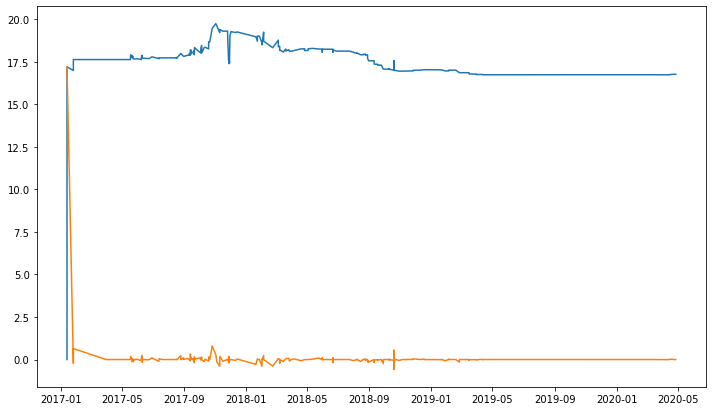

In [26]:
data = averageMetricPerCommitForRepo2(('bptlab', 'scylla'), repoAnalysis.locmOf).data
pyplot.figure(figsize=(12, 7))
deltas = deltasOf(data)
plotByDate(data.values())
plotByDate(deltas.values())

In [104]:
from git import Objects 

ImportError: cannot import name 'Objects' from 'git' (/mnt/brick/home/lbein/jupyter/lib/python3.8/site-packages/git/__init__.py)

In [22]:
%prun averageMetricPerCommitForRepo2(('bptlab', 'scylla'), repoAnalysis.locmOf)

Time used for ('bptlab', 'scylla'): 55.02015924453735
 

         7203932 function calls (7203924 primitive calls) in 55.097 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    64859   20.157    0.000   20.157    0.000 {method 'findall' of 're.Pattern' objects}
    86357    2.600    0.000    2.600    0.000 {method 'readline' of '_io.BufferedReader' objects}
    86045    1.759    0.000    9.823    0.000 cmd.py:1054(__get_object_header)
   344181    1.366    0.000    2.035    0.000 cmd.py:384(__getattr__)
        1    1.234    1.234   55.093   55.093 <ipython-input-14-5eb8f1cdb17b>:1(averageMetricPerCommitForRepo2)
   112394    1.226    0.000   13.717    0.000 util.py:278(traverse)
   587523    1.125    0.000    1.125    0.000 {built-in method builtins.len}
    86044    1.123    0.000   14.277    0.000 db.py:40(stream)
    86044    1.007    0.000   12.076    0.000 cmd.py:1079(stream_object_data)
    86045    0.930    0.000    0.930    0.000 {method 'flush' of '_io.BufferedWriter' o

In [91]:
%prun averageMetricPerCommitForRepo2(('ESSICS', 'org.csstudio.display.builder'), repoAnalysis.locmOf)

Time used for ('ESSICS', 'org.csstudio.display.builder'): 6315.821995258331
 

         1171619199 function calls (1168788979 primitive calls) in 6315.950 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  2357029  845.553    0.000  845.553    0.000 {method 'findall' of 're.Pattern' objects}
  5461182  622.436    0.000 1103.490    0.000 fun.py:621(apply_delta_data)
252555280  558.423    0.000  558.423    0.000 {method 'write' of 'mmap.mmap' objects}
16794917/14262492  316.098    0.000  664.328    0.000 stream.py:215(read)
140949238  267.361    0.000  267.361    0.000 {built-in method builtins.len}
  2292344  260.957    0.000 2433.863    0.001 stream.py:405(_set_cache_brute_)
 12141441  183.001    0.000  333.239    0.000 mman.py:104(use_region)
 42204920  175.195    0.000  266.706    0.000 util.py:119(byte_ord)
  8801310  168.564    0.000  897.650    0.000 pack.py:76(pack_object_at)
 12916875  136.942    0.000  136.942    0.000 {method 'decompress' of 'zlib.Decompress' objects}
 29930951  119.558    0.0

## Lab for new metrics

In [293]:
x = '''
/**
Cool javadoc that shows how cool the class is
*/
public class Foo extends Bar {//Hidden comment
    /**Documentation for a*/
    public static Object b;
    //Docu for b
    public String/*Mean inline comment*/ b;
    /* Another
    Multiline*/

    public static void main(String[] args) {
        //Comment
        //Comment
        System.out.println("Actual code goes here /*hihu*/")

    }
}
'''

#woComments = lambda content: re.sub(r"//.*|(\"(?:\\\\[^\"]|\\\\\"|.)*?\")|(?s)/\\*.*?\\*/", "\g<1> ", content);
stringRemover = re.compile(r"\".*?\"")
pattern = re.compile(r"//.*?\n|/\*.*?\*/", re.S)

matches = pattern.findall(stringRemover.sub("\"...\"", x))
print(sum(map(lambda x: len(x.rstrip().split("\n")), matches)))


11


In [288]:
%autoreload
data = averageMetricPerCommitForRepo(('bptlab', 'scylla'), repoAnalysis.indentPerLoc).data

Time used for ('bptlab', 'scylla'): 9.71684455871582


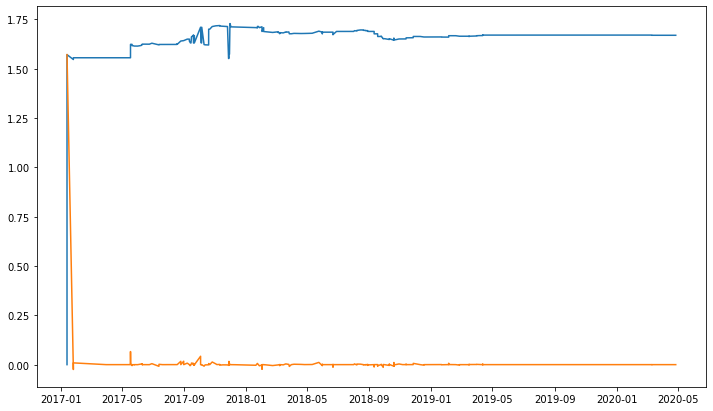

In [289]:
pyplot.figure(figsize=(12, 7))
deltas = deltasOf(data)
plotByDate(data.values())
plotByDate(deltas.values())

In [287]:
y = '''
    indent_1
	    indent_2
        indent_2
'''
indents = list(map(lambda line: len(line[:(len(line)-len(line.lstrip()))].replace('\t', '    ')) / 4, y.split('\n')))
avg = sum(indents)/len(indents)
print(avg)

1.0


In [294]:
repoAnalysis.numMethods(x)

1